#### Model

import numpy as np
import os
import sys
from ultralytics import YOLO
from PIL import Image
import torch
from torch import tensor
from torchvision.transforms import transforms, InterpolationMode
import timm
import torch.nn as nn
import pandas as pd

In [ ]:
DFPATH = 'models'
DFYOLO_NAME = "deepfaune-yolov8s_960"
BACKBONE = "vit_large_patch14_dinov2.lvd142m"
DFYOLO_WEIGHTS = os.path.join(DFPATH,'deepfaune-yolov8s_960.pt')
DFVIT_WEIGHTS = os.path.join(DFPATH,'deepfaune-vit_large_patch14_dinov2.lvd142m.v4.pt')

CROP_SIZE = 560 # default 182, has to be divisible by 14, 280?
DFYOLO_WIDTH = 960 # image width
DFYOLO_THRES = 0.6
DFYOLOHUMAN_THRES = 0.4 # boxes with human above this threshold are saved
DFYOLOCOUNT_THRES = 0.6

txt_animalclasses = {
   'en': ['bison', 'badger', 'ibex', 'beaver', 'red deer', 'golden jackal',
          'chamois', 'cat', 'goat', 'roe deer', 'dog', 'raccoon dog',
          'fallow deer', 'squirrel', 'moose', 'equid', 'genet', 'wolverine',
          'hedgehog', 'lagomorph', 'wolf', 'otter', 'lynx', 'marmot',
          'micromammal', 'mouflon', 'sheep', 'mustelid', 'bird', 'bear',
          'porcupine', 'nutria', 'muskrat', 'raccoon', 'fox', 'reindeer',
          'wild boar', 'cow']
}


class Detector:
    def __init__(self, name=DFYOLO_NAME, threshold=None, countthreshold=None, humanthreshold=None):
        print("Using "+DFYOLO_NAME+" with weights at "+DFYOLO_WEIGHTS+", in resolution 960x960")
        self.yolo = YOLO(DFYOLO_WEIGHTS)
        self.imgsz = DFYOLO_WIDTH
        self.threshold = DFYOLO_THRES if threshold is None else threshold
        self.countthreshold = DFYOLOCOUNT_THRES if countthreshold is None else countthreshold
        self.humanthreshold = DFYOLOHUMAN_THRES if humanthreshold is None else humanthreshold

    def bestBoxDetection(self, filename_or_imagecv):
        try:
            results = self.yolo(filename_or_imagecv, verbose=False, imgsz=self.imgsz)
        except FileNotFoundError:
            print(f"File '{filename_or_imagecv}' not found")
            return None, 0, np.zeros(4), 0, []
        except Exception as err:
            print(err)
            return None, 0, np.zeros(4), 0, []

        # orig_img a numpy array (cv2) in BGR
        imagecv = results[0].cpu().orig_img
        detection = results[0].cpu().numpy().boxes

        # Are there any relevant boxes?
        if not len(detection.cls) or detection.conf[0] < self.threshold:
            # No. Image considered as empty
            return None, 0, np.zeros(4), 0, []
        else:
            # Yes. Non empty image
            pass
        # Is there a relevant animal box? 
        try:
            # Yes. Selecting the best animal box
            kbox = np.where((detection.cls==0) & (detection.conf>self.threshold))[0][0]
        except IndexError:
            # No: Selecting the best box for another category (human, vehicle)
            kbox = 0

        # categories are 1=animal, 2=person, 3=vehicle and the empty category 0=empty
        category = int(detection.cls[kbox]) + 1
        box = detection.xyxy[kbox] # xmin, ymin, xmax, ymax

        # Is this an animal box ?
        if category == 1:
            # Yes: cropped image is required for classification
            croppedimage = cropSquareCVtoPIL(imagecv, box.copy())
        else: 
            # No: return none
            return None, 0, np.zeros(4), 0, []
        
        ## animal count
        if category == 1:
            count = sum((detection.conf>self.countthreshold) & (detection.cls==0)) # only above a threshold
        else:
            count = 0
        ## human boxes
        ishuman = (detection.cls==1) & (detection.conf>=self.humanthreshold)
        if any(ishuman==True):
            humanboxes = detection.xyxy[ishuman,]
        else:
            humanboxes = []

        return croppedimage, category, box, count, humanboxes


def cropSquareCVtoPIL(imagecv, box):
    x1, y1, x2, y2 = box
    xsize = (x2-x1)
    ysize = (y2-y1)
    if xsize>ysize:
        y1 = y1-int((xsize-ysize)/2)
        y2 = y2+int((xsize-ysize)/2)
    if ysize>xsize:
        x1 = x1-int((ysize-xsize)/2)
        x2 = x2+int((ysize-xsize)/2)
    height, width, _ = imagecv.shape
    croppedimagecv = imagecv[max(0,int(y1)):min(int(y2),height),max(0,int(x1)):min(int(x2),width)]
    croppedimage = Image.fromarray(croppedimagecv[:,:,(2,1,0)]) # converted to PIL BGR image
    return croppedimage


class Classifier:

    def __init__(self):
        self.model = Model()
        self.model.loadWeights(DFVIT_WEIGHTS)
        # transform image to form usable by network
        self.transforms = transforms.Compose([
            transforms.Resize(size=(CROP_SIZE, CROP_SIZE), interpolation=InterpolationMode.BICUBIC, max_size=None, antialias=None),
            transforms.ToTensor(),
            transforms.Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))])

    def predictOnBatch(self, batchtensor, withsoftmax=True):
        return self.model.predict(batchtensor, withsoftmax)

    # croppedimage loaded by PIL
    def preprocessImage(self, croppedimage):
        preprocessimage = self.transforms(croppedimage)
        return preprocessimage.unsqueeze(dim=0)


class Model(nn.Module):
    def __init__(self):
        """
        Constructor of model classifier
        """
        super().__init__()
        self.base_model = timm.create_model(BACKBONE, pretrained=False, num_classes=len(txt_animalclasses['en']),
                                            dynamic_img_size=True)
        print(f"Using {BACKBONE} with weights at {DFVIT_WEIGHTS}, in resolution {CROP_SIZE}x{CROP_SIZE}")
        self.backbone = BACKBONE
        self.nbclasses = len(txt_animalclasses['en'])

    def forward(self, input):
        x = self.base_model(input)
        return x

    def predict(self, data, withsoftmax=True):
        """
        Predict on test DataLoader
        :param test_loader: test dataloader: torch.utils.data.DataLoader
        :return: numpy array of predictions without soft max
        """
        self.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        total_output = []
        with torch.no_grad():
            x = data.to(device)
            if withsoftmax:
                output = self.forward(x).softmax(dim=1)
            else:
                output = self.forward(x)
            total_output += output.tolist()

        return np.array(total_output)

    def loadWeights(self, path):
        """
        :param path: path of .pt save of model
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("CUDA available" if torch.cuda.is_available() else "CUDA unavailable. Using CPU")

        try:
            params = torch.load(path, map_location=device, weights_only=False)
            args = params['args']
            if self.nbclasses != args['num_classes']:
                raise Exception("You load a model ({}) that does not have the same number of class"
                                "({})".format(args['num_classes'], self.nbclasses))
            self.backbone = args['backbone']
            self.nbclasses = args['num_classes']
            self.load_state_dict(params['state_dict'])
        except Exception as e:
            print("Can't load checkpoint model because :\n\n " + str(e), file=sys.stderr)
            raise e

In [ ]:
from datetime import datetime
detector = Detector()
classifier = Classifier()

images = pd.read_csv('../y_clean.csv', index_col=0)
images.RelativePath = images.RelativePath.str.replace('\\', '/')
results = pd.DataFrame({'image': [], 'detected_animal': []})
currently_classifying = images.iloc[0,1].rsplit('/')[0]
print('Currently: ' + currently_classifying)

for _, row in images.iterrows():
    if currently_classifying != row['RelativePath'].rsplit('/')[0]:
        currently_classifying = row['RelativePath'].rsplit('/')[0]
        print('Currently: ' + currently_classifying)
    image_path = '../../pictures/' + row['RelativePath'] + '/' + row['File']
    croppedimage, category, box, count, humanboxes = detector.bestBoxDetection(image_path)

    if croppedimage is not None:
        cropped_tensor = torch.ones((1,3,CROP_SIZE,CROP_SIZE))
        cropped_tensor[0,:,:,:] =  classifier.preprocessImage(croppedimage)
        scores = classifier.model.predict(cropped_tensor)
        output = pd.DataFrame({'species':txt_animalclasses['en'], 'score':scores[0][:]})
        output = output[output['score'] > 0.1]

        if output.empty:
            results.loc[len(results)] = [image_path, 'empty']
        else:
            results.loc[len(results)] = [image_path, output.loc[output['score'].idxmax(), 'species']]
    else:
        results.loc[len(results)] = [image_path, 'empty']

now = datetime.now().strftime('%Y_%m_%d_%H_%M')
results.to_csv('results/results_deepfaune' + now + '.csv')

#### Unification

In [1]:
import pandas as pd
import numpy as np

In [2]:
RESULTS_FILE = 'deepfaune/results/results_deepfaune2025_11_05_13_58.csv'

In [4]:
expected_results = pd.read_csv('y_clean.csv', index_col=0)
model_results = pd.read_csv(RESULTS_FILE, index_col=0)

expected_results = expected_results[expected_results.species != 'human']
model_results = model_results.rename(columns={'detected_animal': 'species_model'})

expected_results['image'] = '../../pictures/' + \
    expected_results.RelativePath.str.replace('\\', '/') + \
    '/' + expected_results.File
expected_results = expected_results[['image', 'species']]
expected_results.head()

merged = pd.merge(expected_results, model_results, on='image', how='left')

merged.species = merged.species.replace('Empty', 'empty')
merged.species = merged.species.replace('Undefined', 'other')
merged.species = merged.species.replace('reddeer', 'red deer')
merged.species = merged.species.replace('roedeer', 'roe deer')
merged.species = merged.species.replace(['marten', 'weasel', 'stoat', 'mink', 'polecat'], 'mustelid')
merged.species = merged.species.replace('wildboar', 'wild boar')

merged.species_model = merged.species_model.replace('lagomorph', 'hare')
merged.species_model = merged.species_model.replace('golden jackal', 'wolf')
merged.species_model = merged.species_model.replace(
    ['nutria', 'marmot', 'raccoon'],
    'beaver'
)
merged.species_model = merged.species_model.replace('cow', 'bison')
merged.species_model = merged.species_model.replace(
    ['chamois', 'equid', 'goat', 'ibex', 'micromammal', 'mouflon'],
    'other'
)
merged.species_model = merged.species_model.replace('reindeer', 'red deer')

merged['model_correct'] = merged.species == merged.species_model

#### Statistics

##### All

In [6]:
N = len(merged)
n_model_correct = np.sum(merged.model_correct)

print(f'Accuracy: {100 * n_model_correct / N: .2f}%')

display(merged[~merged.model_correct].species.value_counts())

accuracy_per_species = (
    merged.groupby('species')
      .agg(
          accuracy=('model_correct', 'mean'),  # mean(True/False)
          count=('model_correct', 'size')      # number of samples
      )
      .sort_values('accuracy', ascending=False)
)
display(accuracy_per_species)

Accuracy:  80.04%


species
red deer       1557
roe deer        974
beaver          726
bird            619
other           541
fox             366
wild boar       276
mustelid        249
bison           117
squirrel        113
wolf            106
vehicle          94
rodent           92
wildcat          70
moose            53
badger           47
otter            23
hare             22
empty            21
bear             17
raccoon dog      14
fallow deer      10
lynx              9
dog               7
cat               3
Name: count, dtype: int64

,accuracy,count
species,,
empty,0.958167,502
fallow deer,0.891304,92
bear,0.878571,140
red deer,0.875450,12501
roe deer,0.871977,7608
bison,0.863158,855
dog,0.857143,49
fox,0.829291,2144
cat,0.823529,17


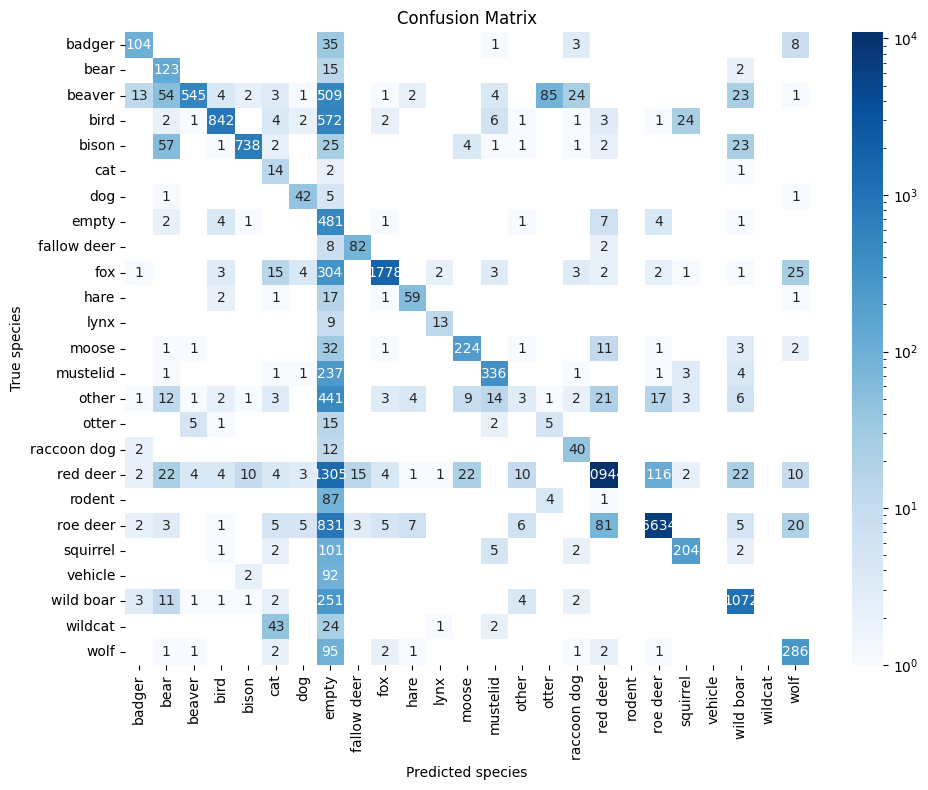

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix

# Create confusion matrix
labels = sorted(merged['species'].unique())  # consistent ordering
cm = confusion_matrix(merged['species'], merged['species_model'], labels=labels)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            norm=LogNorm(vmin=1, vmax=cm.max()))
plt.xlabel("Predicted species")
plt.ylabel("True species")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

##### No empty

In [9]:
merged_no_empty = merged[(merged.species_model != 'empty') | (merged.species == 'empty')]

N = len(merged_no_empty)
n_model_correct = np.sum(merged_no_empty.model_correct)

print(f'Speciesnet accuracy: {100 * n_model_correct / N: .2f}%')

display(merged_no_empty[~merged_no_empty.model_correct].species.value_counts())

accuracy_per_species = (
    merged_no_empty.groupby('species')
      .agg(
          accuracy=('model_correct', 'mean'),  # mean(True/False)
          count=('model_correct', 'size')      # number of samples
      )
      .sort_values('accuracy', ascending=False)
)
display(accuracy_per_species)

Speciesnet accuracy:  95.71%


species
red deer       252
beaver         217
roe deer       143
other          100
bison           92
fox             62
bird            47
wildcat         46
wild boar       25
empty           21
moose           21
mustelid        12
squirrel        12
badger          12
wolf            11
otter            8
rodent           5
hare             5
bear             2
raccoon dog      2
dog              2
fallow deer      2
vehicle          2
cat              1
Name: count, dtype: int64

,accuracy,count
species,,
lynx,1.000000,13
bear,0.984000,125
roe deer,0.978899,6777
red deer,0.977492,11196
wild boar,0.977211,1097
fallow deer,0.976190,84
fox,0.966304,1840
mustelid,0.965517,348
wolf,0.962963,297


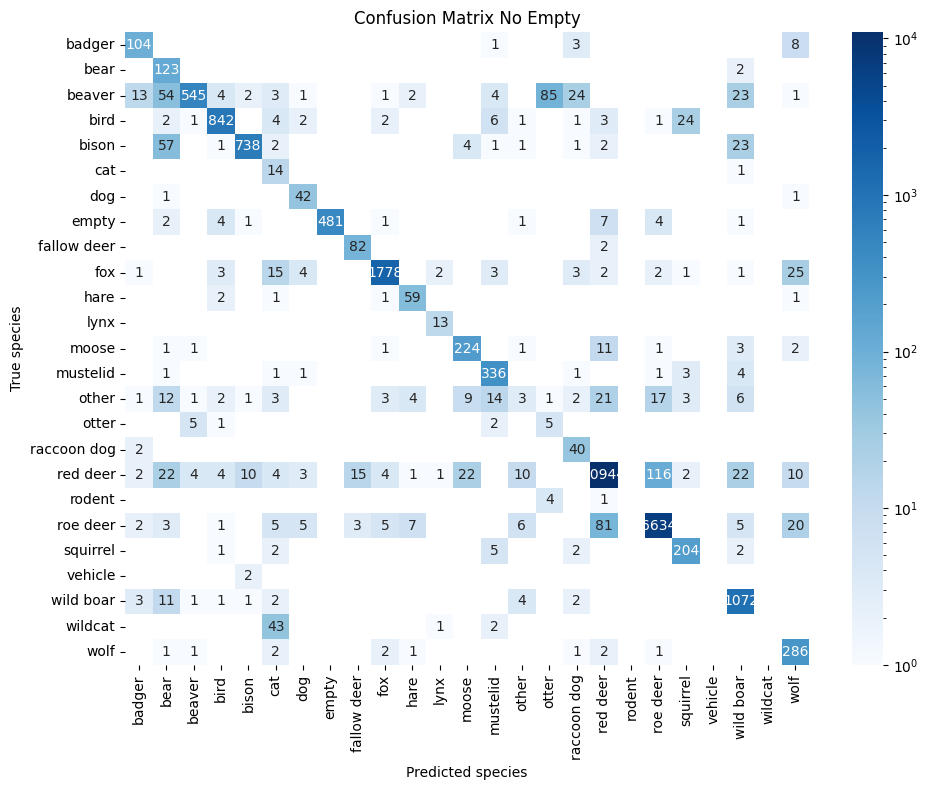

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix

# Create confusion matrix
labels = sorted(merged_no_empty['species'].unique())  # consistent ordering
cm = confusion_matrix(merged_no_empty['species'], merged_no_empty['species_model'], labels=labels)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            norm=LogNorm(vmin=1, vmax=cm.max()))
plt.xlabel("Predicted species")
plt.ylabel("True species")
plt.title("Confusion Matrix No Empty")
plt.tight_layout()
plt.show()